# The vertical Sato-Tate-Distribution



In [3]:
import matplotlib.pyplot as plt
import numpy as np
from math import asin, log, sqrt

def ecs_over_F(p):
    F = GF(p)
    the_1728_j = F(1728)

    js = list(range(1,p))
    js.remove(the_1728_j) #needs to be handled separately
    cardinalities = np.array([])
    for j in my_simple_js:
        E = EllipticCurve_from_j(F(j), minimal_twist=False)
        np.append(cardinalities, E.cardinality())
        # |E| + |E'| = 2p+2
    cardinalities = (cardinalities - (p+1))/float(2 * sqrt(p))
    np.append(cardinalities, -cardinalities)
    return cardinalities

def normalized_aps(p):
    F = GF(p)
    the_1728_j = F(1728)

    js = list(range(1,p))
    js.remove(the_1728_j) #needs to be handled separately
    without_twist_aps = (np.array([EllipticCurve_from_j(F(j), minimal_twist=False).cardinality() for j in js]) - (p+1))/float(2 * sqrt(p))

    all_aps = np.append(without_twist_aps, -without_twist_aps)
    return all_aps

def fast_aplist(p):
    ap_list = np.array([])
    for a in range(0, int(2 * sqrt(p))):
        hurwitz_number = int(pari(int(4*p - a^2)).qfbhclassno()) #need to change sign because of implementaion of hurwitz class number
        list = np.zeros(hurwitz_number)
        list += a/float(2 * sqrt(p))
        ap_list = np.append(ap_list, list)
        if a != 0:
            ap_list = np.append(ap_list, -list)
    return ap_list

def histogram(v, num_bins, p):
    n, bins, patches = plt.hist(v, num_bins, density=True)
    angle = np.linspace(0, np.pi, 150) 
    radius = 1
    x = radius * np.cos(angle) 
    y = radius * np.sin(angle) * 2 / np.pi #stretching so that area = 1
    plt.plot(x, y)
    plt.xlabel('$a_p/\\sqrt{p}$')
    plt.ylabel('Frequency')
    plt.title('Vertical Sato-Tate-Distribution for p = {}'.format(p))
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(-1,1)
    #plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

In [ ]:
p = 99991
v = normalized_aps(p)
histogram(v, 30, p)

In [4]:
import bisect

def liney(y, xmin,xmax):
    return line([(xmin,y),(xmax,y)], rgbcolor=(1,0,0))

def Xab(a,b):
    bb = (asin(b)/2r + b*sqrt(1r-b^2r)/2r)
    aa = (asin(a)/2r + a*sqrt(1r-a^2r)/2r)
    def X(T):
        return (asin(T)/2r + T*sqrt(1r-T^2r)/2r - aa)/(bb - aa)
    return X

def sorted_aplist(p):
    v = fast_aplist(p)
    v.sort()
    return v

def Ypab(p, a=-1, b=1):
    v = sorted_aplist(p)
    denom = bisect.bisect_right(v, float(b)) - bisect.bisect_left(v, float(a))
    try:
        normalize = float(1)/denom
    except:
        def Y(T):
            return 1.0r
        return Y
    start_pos = bisect.bisect_left(v, float(a))

    def Y(T):
        # find position that T would go in if it were inserted
        # in the sorted list v.
        n = bisect.bisect_right(v, float(T)) - start_pos
        return n * normalize
    return Y

global _delta

def Delta(p, a, b, max_points=300):
    """
    Delta_{a}^{b} function:
    INPUT: C - cutoff
    a,b - evaluate over the interval (a,b)
    max_points - number of points used in numerical integral
    """
    global _delta
    key = (p,a,b,max_points)
    try:
        return _delta[key]
    except NameError:
        _delta = {}
    except KeyError:
        pass
    X = Xab(a,b)
    Y = Ypab(p,a,b)
    def h(T):
        return (X(T) - Y(T))^2r
    
    val, err = integral_numerical(h, a, b, max_points=max_points, algorithm='qag', rule=1, eps_abs=1e-10, eps_rel=1e-10)
    
    _delta[key] = (val, err)
    if verbose:
        print("p: ", p, " val: ", val)
    return val, err

def plot_Delta(pmax, step_size=10, max_points=100, a=-1, b=1):
    v = [(p,Delta(p, a, b, max_points=max_points)[0]) for p in prime_range(10,pmax)[::step_size]]
    return line(v,rgbcolor=(0,0,0), ymin=0, ymax=0.1)

#plot_Delta(10000)

In [7]:
def theta(p, a=-1, b=1, max_points=300):
    val, err = Delta(p, a, b, max_points=max_points)
    return -log(val)/log(p), val, err

def theta_interval(p, a=-1, b=1, max_points=300):
    val, err = Delta(p, a, b, max_points=max_points)
    return -log(val-abs(err))/log(p), -log(val+abs(err))/log(p)

def compute_theta(p, step_size=None, a=-1, b=1, max_points=300, verbose=False):
    a,b = (float(a), float(b))
    if not step_size:
        step_size = max(1, int(p/(20 * log(p)))) # grows with pi(p)

    def f(p):
        z = theta(p, a, b, max_points=max_points)
        if verbose: print(p, z)
        return z[0]

    #calls theta (= log etc. angewandt auf Delta)
    return [(x,f(x)) for x in prime_range(100, p)[::step_size]]

def compute_theta_interval(p, step_size=None, a=-1, b=1, max_points=300, verbose=False):
    a,b = (float(a), float(b))
    if not step_size:
        step_size = max(1, int(p/(20 * log(p)))) # grows with pi(p)
    vmin = []; vmax = []
    for C in prime_range(100, p)[::step_size]:
        zmin,zmax = theta_interval(C, a, b, max_points=max_points)
        vmin.append((C, zmin))
        vmax.append((C, zmax))
        if verbose: 
            print(C, zmin, zmax)
    return vmin, vmax

def plot_theta_interval(p, clr=(0,0,0), *args, **kwds):
    vmin, vmax = compute_theta_interval(p, *args, **kwds)
    v = compute_theta(p, *args, **kwds)
    grey = (0.7,0.7,0.7)
    return line(vmin,rgbcolor=grey, ymin=0,ymax=1.5) + line(vmax,rgbcolor=grey) + point(v,rgbcolor=clr) + line(v,rgbcolor=clr) + liney(1,0, p)

def plot_theta(p, clr=(0,0,0), *args, **kwds):
    v = compute_theta(p, *args, **kwds)
    return point(v,rgbcolor=clr, ymin=0, ymax=2) + line(v, rgbcolor=clr) + liney(1.2,0,p)

#plot_theta_interval(1000000, a=-.1,b=.1, max_points = 500)

In [10]:
p = prime_range(10000000)[-1]
print(p)
val, err = Delta(p, -1,1, max_points=100)
print(val)
theta = -log(val)/log(p)
print(theta)

9999991
p:  9999991  val:  7.555083577005925e-09
1.1602515972116065


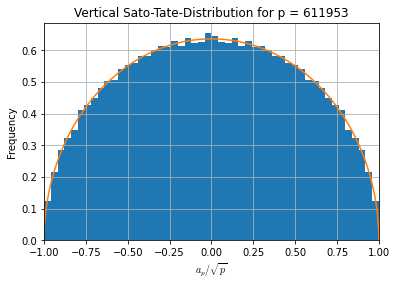

In [8]:
import numpy as np
p = 611953

def fast_ap_list(p):
    ap_list = np.array([])
    for a in range(0, int(2 * sqrt(p))):
        hurwitz_number = int(pari(int(4*p - a^2)).qfbhclassno()) #need to change sign because of implementaion of hurwitz class number
        list = np.zeros(hurwitz_number) #
        list += a/float(2 * sqrt(p))
        ap_list = np.append(ap_list, list)
        if a != 0:
            ap_list = np.append(ap_list, -list)
    return ap_list


histogram(fast_ap_list(p), 50, p)

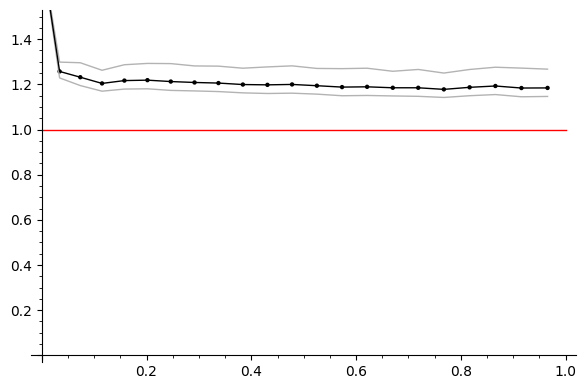

In [9]:
plot_theta_interval(1000000, max_points = 500)

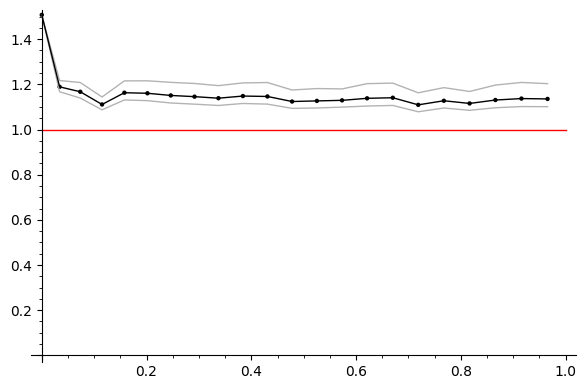

In [10]:
plot_theta_interval(1000000, a=-.5,b=.5, max_points = 500)

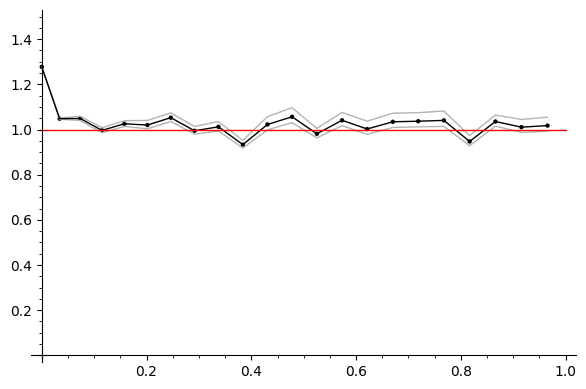

In [11]:
plot_theta_interval(1000000, a=-.1,b=.1, max_points = 300)

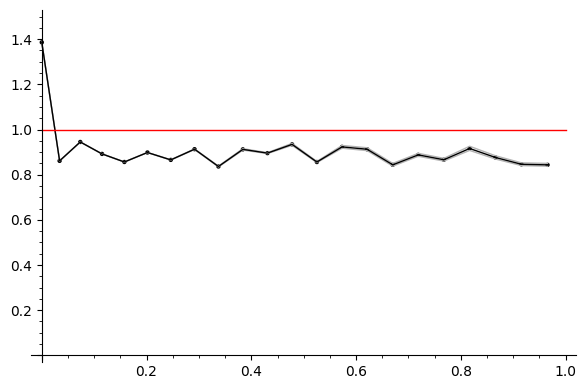

In [12]:
plot_theta_interval(1000000, a=-.01,b=.01, max_points = 100)

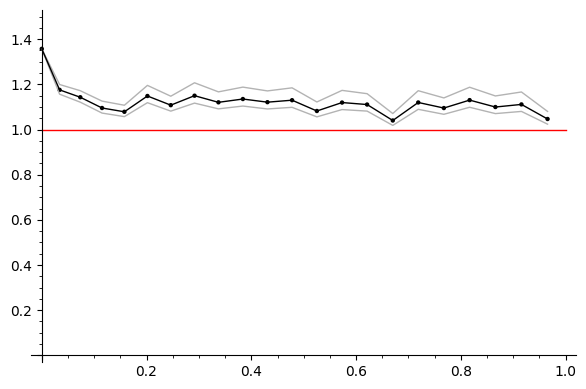

In [13]:
plot_theta_interval(1000000, a=0,b=1, max_points = 500)

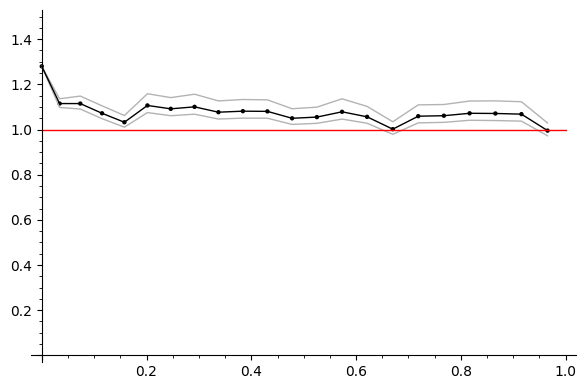

In [14]:
plot_theta_interval(1000000, a=0,b=.5, max_points = 300)

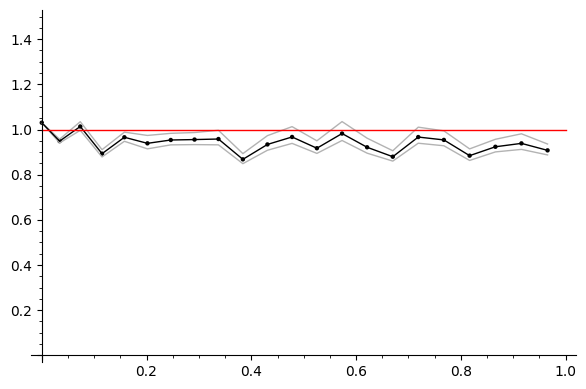

In [15]:
plot_theta_interval(1000000, a=0,b=.1, max_points = 100)

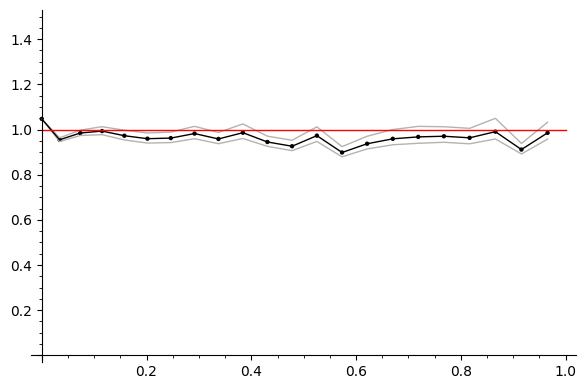

In [16]:
plot_theta_interval(1000000, a=.9,b=1, max_points = 100)

Computing the convergence rate up to primes of magnitude 10e6 < p < 10e7 rather suggests a limit of 1.16 or something comparable instead of the 1.3 I thought of before for $(-1,1)$.

This would imply $\lim_{p \to \infty} \log(\Delta)/\log(p) = 1+\epsilon$, i.e.

$$\Delta = \mathcal O(p^{1+\epsilon})$$


where $\Delta$ is the L2-norm squared and epsilon would be something around .15.